In [1]:
from image_preprocessing import get_labels, get_combined_generator, MultimodalDataGenerator
from models import build_multiscale_cnn
from utils import get_patch_list 

from config import *

C:\Users\augus\miniconda3\envs\new_env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc, RocCurveDisplay
import tensorflow as tf
from tensorflow.keras.optimizers import AdamW

import matplotlib.pyplot as plt
import os

import random
import warnings


from codecarbon import EmissionsTracker

warnings.filterwarnings("ignore")

# Parameters

In [3]:
NUM_CLASSES = 1
IMAGE_SIZE = 128

# DATA
BATCH_SIZE = 8

# OPTIMIZER
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# TRAINING
EPOCHS = 400

In [4]:
sites = ["fao", "roudoudour", "timbertiere", "cisse", "louroux"]
variables = ["image_patches", "dtm_patches", "dsm_patches"]
order = "plecoptera"

# Import and split data paths

In [5]:
train_patches = np.stack([get_patch_list(train_patches_output_dir, i, sites=sites) for i in variables], axis=-1)
test_patches = np.stack([get_patch_list(test_patches_output_dir, i, sites=sites) for i in variables], axis=-1)
val_patches = np.stack([get_patch_list(val_patches_output_dir, i, sites=sites) for i in variables], axis=-1)

train_image_patches = get_patch_list(train_patches_output_dir, "image_patches", sites=sites)
test_image_patches = get_patch_list(test_patches_output_dir, "image_patches", sites=sites)
val_image_patches = get_patch_list(val_patches_output_dir, "image_patches", sites=sites)

In [6]:
train_patches.shape, test_patches.shape, val_patches.shape

((149, 3), (48, 3), (37, 3))

In [7]:
df_labels = pd.read_csv(labels_path, index_col="Unnamed: 0")

In [8]:
train_labels = get_labels(df_labels, train_image_patches, order)
test_labels = get_labels(df_labels, test_image_patches, order)
val_labels = get_labels(df_labels, val_image_patches, order)

In [9]:
train_selected_indices = random.sample(range(len(train_labels)), len(train_labels))
test_selected_indices = random.sample(range(len(test_labels)), len(test_labels))
val_selected_indices = random.sample(range(len(val_labels)), len(val_labels))

In [10]:
train_patches = [train_patches[i] for i in train_selected_indices]
train_labels = [train_labels[i] for i in train_selected_indices]

val_patches = [val_patches[i] for i in val_selected_indices]
val_labels = [val_labels[i] for i in val_selected_indices]

test_patches = [test_patches[i] for i in test_selected_indices]
test_labels = [test_labels[i] for i in test_selected_indices]

# np.array(test_labels)[pd.Index(test_labels).notna()]

# autoencoder_paths = train_image_paths + test_image_paths

In [11]:
labels = train_labels + val_labels + test_labels
print(f"proportion of Ephemeropteres in whole dataset: {round(np.sum(np.array(labels) > 0)/len(labels), 3)}%")
print(f"proportion of Ephemeropteres in train dataset: {round(np.sum(np.array(train_labels) > 0)/len(train_labels), 3)}%")
print(f"proportion of Ephemeropteres in val dataset: {round(np.sum(np.array(val_labels) > 0)/len(val_labels), 3)}%")
print(f"proportion of Ephemeropteres in test dataset: {round(np.sum(np.array(test_labels) > 0)/len(test_labels), 3)}%")

proportion of Ephemeropteres in whole dataset: 0.496%
proportion of Ephemeropteres in train dataset: 0.537%
proportion of Ephemeropteres in val dataset: 0.432%
proportion of Ephemeropteres in test dataset: 0.417%


# Load and preprocess data

In [12]:
train_gen = get_combined_generator(
    img_paths=train_patches, batch_size=8, labels=train_labels, mixup_second_gen=True
)
test_gen = MultimodalDataGenerator(
    img_paths=test_patches, batch_size=8, labels=test_labels, shuffle=False
)
val_gen = MultimodalDataGenerator(
    img_paths=val_patches, batch_size=8, labels=val_labels, shuffle=False
)

In [13]:
batch = train_gen.__getitem__(0)

In [14]:
batch[1]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       0.41483694, 1.        , 1.        ])

In [15]:
batch[0].shape

(8, 128, 128, 7)

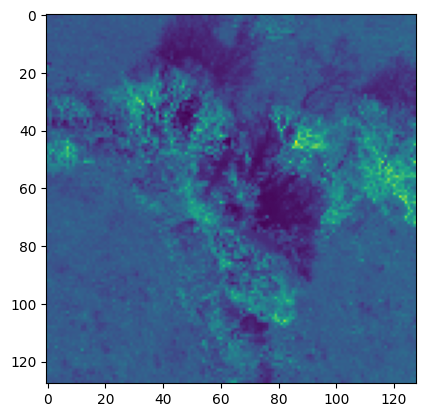

In [16]:
plt.imshow(batch[0][3,:,:,0])

# Define and compile model

In [17]:
# Example usage
model = build_multiscale_cnn(input_shape=(IMAGE_SIZE, IMAGE_SIZE, len(variables) if "image_patches" not in variables else len(variables)+4), num_classes=1)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 7)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         2048      ['input_1[0][0]']             
                                                                                                  
 conv2d_2 (Conv2D)           (None, 128, 128, 32)         5632      ['input_1[0][0]']             
                                                                                                  
 conv2d_4 (Conv2D)           (None, 128, 128, 32)         11008     ['input_1[0][0]']             
                                                                                              

In [18]:
optimizer = AdamW(
    learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="accuracy"),
        tf.keras.metrics.AUC(name='auc')
        # keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
    ],
)

# Train model

In [19]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=max([5, EPOCHS//10]), restore_best_weights=True),
            ]

tracker = EmissionsTracker(experiment_id='CO2_tracking', 
                           measure_power_secs=180, 
                           allow_multiple_runs=True)
tracker.start()
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)


[codecarbon WARNING @ 17:31:43] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 17:31:43] [setup] RAM Tracking...
[codecarbon INFO @ 17:31:43] [setup] GPU Tracking...
[codecarbon INFO @ 17:31:44] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 17:31:44] [setup] CPU Tracking...
[codecarbon WARNING @ 17:31:44] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 17:31:46] We saw that you have a Intel(R) Core(TM) Ultra 5 135H but we don't know it. Please contact us.
[codecarbon INFO @ 17:31:46] CPU Model on constant consumption mode: Intel(R) Core(TM) Ultra 5 135H
[codecarbon INFO @ 17:31:46] >>> Tracker's metadata:
[codecarbon INFO @ 17:31:46]   Platform system: Windows-10-10.0.19041-SP0
[codecarbon INFO @ 17:31:46]   Python version: 3.8.2
[codecarbon INFO @ 17:31:46]   CodeCarbon version: 2.7.4
[codecarbon INFO @ 17:31:46]   Available RAM : 

Epoch 1/400
38/38 [==============================] - 33s 824ms/step - loss: 0.6184 - accuracy: 0.5772 - auc: 0.6460 - val_loss: 0.6473 - val_accuracy: 0.5676 - val_auc: 0.8423
Epoch 2/400
38/38 [==============================] - 19s 496ms/step - loss: 0.4613 - accuracy: 0.6242 - auc: 0.8246 - val_loss: 0.6629 - val_accuracy: 0.5676 - val_auc: 0.8824
Epoch 3/400
38/38 [==============================] - 19s 484ms/step - loss: 0.4464 - accuracy: 0.6409 - auc: 0.8605 - val_loss: 0.7338 - val_accuracy: 0.5405 - val_auc: 0.8810
Epoch 4/400
38/38 [==============================] - 18s 478ms/step - loss: 0.5003 - accuracy: 0.6443 - auc: 0.8243 - val_loss: 0.5532 - val_accuracy: 0.8649 - val_auc: 0.9196
Epoch 5/400
38/38 [==============================] - 20s 527ms/step - loss: 0.4111 - accuracy: 0.6980 - auc: 0.8712 - val_loss: 0.4681 - val_accuracy: 0.7838 - val_auc: 0.9345
Epoch 6/400
38/38 [==============================] - 20s 496ms/step - loss: 0.4055 - accuracy: 0.6711 - auc: 0.8637 - va

[codecarbon INFO @ 17:34:50] Energy consumed for RAM : 0.000591 kWh. RAM Power : 11.79664421081543 W


11/38 [=======>......................] - ETA: 12s - loss: 0.3599 - accuracy: 0.6818 - auc: 0.8702

[codecarbon INFO @ 17:34:51] Energy consumed for all GPUs : 0.000009 kWh. Total GPU Power : 0.17227095326673947 W
[codecarbon INFO @ 17:34:51] Energy consumed for all CPUs : 0.002149 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:34:51] 0.002749 kWh of electricity used since the beginning.


38/38 [==============================] - 21s 545ms/step - loss: 0.4162 - accuracy: 0.6846 - auc: 0.8428 - val_loss: 0.5676 - val_accuracy: 0.7568 - val_auc: 0.8839
Epoch 10/400
38/38 [==============================] - 18s 484ms/step - loss: 0.3489 - accuracy: 0.7047 - auc: 0.9009 - val_loss: 0.3662 - val_accuracy: 0.8919 - val_auc: 0.9390
Epoch 11/400
38/38 [==============================] - 20s 509ms/step - loss: 0.3811 - accuracy: 0.7148 - auc: 0.9048 - val_loss: 0.4043 - val_accuracy: 0.8649 - val_auc: 0.9345
Epoch 12/400
38/38 [==============================] - 18s 462ms/step - loss: 0.3635 - accuracy: 0.6946 - auc: 0.8648 - val_loss: 0.4758 - val_accuracy: 0.8378 - val_auc: 0.9405
Epoch 13/400
38/38 [==============================] - 18s 471ms/step - loss: 0.3518 - accuracy: 0.7114 - auc: 0.9013 - val_loss: 0.3663 - val_accuracy: 0.8108 - val_auc: 0.9435
Epoch 14/400
38/38 [==============================] - 17s 457ms/step - loss: 0.3197 - accuracy: 0.7349 - auc: 0.9147 - val_loss:

[codecarbon INFO @ 17:37:50] Energy consumed for RAM : 0.001176 kWh. RAM Power : 11.79664421081543 W


38/38 [==============================] - 17s 461ms/step - loss: 0.2989 - accuracy: 0.7349 - auc: 0.9195 - val_loss: 0.4797 - val_accuracy: 0.8378 - val_auc: 0.9196
Epoch 19/400


[codecarbon INFO @ 17:37:51] Energy consumed for all GPUs : 0.000025 kWh. Total GPU Power : 0.3310828734812745 W
[codecarbon INFO @ 17:37:51] Energy consumed for all CPUs : 0.004274 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:37:51] 0.005476 kWh of electricity used since the beginning.


38/38 [==============================] - 17s 446ms/step - loss: 0.3009 - accuracy: 0.7215 - auc: 0.8984 - val_loss: 0.5954 - val_accuracy: 0.8108 - val_auc: 0.8929
Epoch 20/400
38/38 [==============================] - 17s 446ms/step - loss: 0.3307 - accuracy: 0.7383 - auc: 0.9015 - val_loss: 0.6383 - val_accuracy: 0.7568 - val_auc: 0.9196
Epoch 21/400
38/38 [==============================] - 20s 517ms/step - loss: 0.2751 - accuracy: 0.7181 - auc: 0.9252 - val_loss: 0.4000 - val_accuracy: 0.8649 - val_auc: 0.9211
Epoch 22/400
38/38 [==============================] - 21s 532ms/step - loss: 0.2768 - accuracy: 0.7416 - auc: 0.9290 - val_loss: 0.5397 - val_accuracy: 0.8649 - val_auc: 0.9390
Epoch 23/400
38/38 [==============================] - 18s 480ms/step - loss: 0.3137 - accuracy: 0.7181 - auc: 0.9092 - val_loss: 0.4104 - val_accuracy: 0.9189 - val_auc: 0.9435
Epoch 24/400
38/38 [==============================] - 21s 554ms/step - loss: 0.2646 - accuracy: 0.7215 - auc: 0.9179 - val_loss:

[codecarbon INFO @ 17:40:50] Energy consumed for RAM : 0.001761 kWh. RAM Power : 11.79664421081543 W


19/38 [==============>...............] - ETA: 6s - loss: 0.2301 - accuracy: 0.7500 - auc: 0.9444

[codecarbon INFO @ 17:40:51] Energy consumed for all GPUs : 0.000033 kWh. Total GPU Power : 0.15211704569686374 W
[codecarbon INFO @ 17:40:51] Energy consumed for all CPUs : 0.006399 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:40:51] 0.008193 kWh of electricity used since the beginning.


38/38 [==============================] - 18s 465ms/step - loss: 0.2616 - accuracy: 0.7550 - auc: 0.9376 - val_loss: 0.9954 - val_accuracy: 0.7027 - val_auc: 0.8795
Epoch 29/400
38/38 [==============================] - 19s 494ms/step - loss: 0.2485 - accuracy: 0.7685 - auc: 0.9301 - val_loss: 0.6253 - val_accuracy: 0.8649 - val_auc: 0.9435
Epoch 30/400
38/38 [==============================] - 21s 531ms/step - loss: 0.2860 - accuracy: 0.7517 - auc: 0.9196 - val_loss: 0.2660 - val_accuracy: 0.8919 - val_auc: 0.9509
Epoch 31/400
38/38 [==============================] - 19s 490ms/step - loss: 0.2744 - accuracy: 0.7215 - auc: 0.9344 - val_loss: 0.5556 - val_accuracy: 0.8919 - val_auc: 0.9167
Epoch 32/400
38/38 [==============================] - 22s 574ms/step - loss: 0.2159 - accuracy: 0.7584 - auc: 0.9565 - val_loss: 0.6661 - val_accuracy: 0.8649 - val_auc: 0.9182
Epoch 33/400
38/38 [==============================] - 18s 478ms/step - loss: 0.2421 - accuracy: 0.7517 - auc: 0.9383 - val_loss:

[codecarbon INFO @ 17:43:50] Energy consumed for RAM : 0.002346 kWh. RAM Power : 11.79664421081543 W


 7/38 [====>.........................] - ETA: 18s - loss: 0.2730 - accuracy: 0.6600 - auc: 0.9395

[codecarbon INFO @ 17:43:51] Energy consumed for all GPUs : 0.000042 kWh. Total GPU Power : 0.1804648739789604 W
[codecarbon INFO @ 17:43:51] Energy consumed for all CPUs : 0.008525 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:43:51] 0.010912 kWh of electricity used since the beginning.


38/38 [==============================] - 19s 493ms/step - loss: 0.2858 - accuracy: 0.7383 - auc: 0.9152 - val_loss: 0.4614 - val_accuracy: 0.8378 - val_auc: 0.9286
Epoch 39/400
38/38 [==============================] - 17s 443ms/step - loss: 0.2401 - accuracy: 0.7483 - auc: 0.9364 - val_loss: 0.4529 - val_accuracy: 0.8919 - val_auc: 0.9420
Epoch 40/400
38/38 [==============================] - 17s 443ms/step - loss: 0.2037 - accuracy: 0.7584 - auc: 0.9514 - val_loss: 0.2917 - val_accuracy: 0.9189 - val_auc: 0.9554
Epoch 41/400
38/38 [==============================] - 17s 450ms/step - loss: 0.2560 - accuracy: 0.7584 - auc: 0.9479 - val_loss: 0.4083 - val_accuracy: 0.8919 - val_auc: 0.9315
Epoch 42/400
38/38 [==============================] - 17s 444ms/step - loss: 0.1728 - accuracy: 0.7852 - auc: 0.9552 - val_loss: 0.3757 - val_accuracy: 0.8919 - val_auc: 0.9360
Epoch 43/400
38/38 [==============================] - 17s 438ms/step - loss: 0.2315 - accuracy: 0.7517 - auc: 0.9561 - val_loss:

[codecarbon INFO @ 17:46:50] Energy consumed for RAM : 0.002931 kWh. RAM Power : 11.79664421081543 W


22/38 [================>.............] - ETA: 7s - loss: 0.2203 - accuracy: 0.7529 - auc: 0.9423

[codecarbon INFO @ 17:46:51] Energy consumed for all GPUs : 0.000050 kWh. Total GPU Power : 0.17840715142515048 W
[codecarbon INFO @ 17:46:51] Energy consumed for all CPUs : 0.010650 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:46:51] 0.013631 kWh of electricity used since the beginning.


38/38 [==============================] - 18s 463ms/step - loss: 0.2124 - accuracy: 0.7517 - auc: 0.9519 - val_loss: 0.3751 - val_accuracy: 0.8919 - val_auc: 0.9390
Epoch 49/400
38/38 [==============================] - 21s 563ms/step - loss: 0.1776 - accuracy: 0.7785 - auc: 0.9743 - val_loss: 0.2554 - val_accuracy: 0.9189 - val_auc: 0.9628
Epoch 50/400
38/38 [==============================] - 18s 462ms/step - loss: 0.1979 - accuracy: 0.7584 - auc: 0.9314 - val_loss: 0.3888 - val_accuracy: 0.8378 - val_auc: 0.9420
Epoch 51/400
38/38 [==============================] - 17s 449ms/step - loss: 0.1934 - accuracy: 0.7718 - auc: 0.9623 - val_loss: 0.6949 - val_accuracy: 0.8378 - val_auc: 0.9509
Epoch 52/400
38/38 [==============================] - 18s 485ms/step - loss: 0.1993 - accuracy: 0.7752 - auc: 0.9624 - val_loss: 0.7168 - val_accuracy: 0.8108 - val_auc: 0.9226
Epoch 53/400
38/38 [==============================] - 18s 465ms/step - loss: 0.1688 - accuracy: 0.7685 - auc: 0.9659 - val_loss:

[codecarbon INFO @ 17:49:50] Energy consumed for RAM : 0.003515 kWh. RAM Power : 11.79664421081543 W


 9/38 [======>.......................] - ETA: 11s - loss: 0.2351 - accuracy: 0.7222 - auc: 0.9171

[codecarbon INFO @ 17:49:51] Energy consumed for all GPUs : 0.000059 kWh. Total GPU Power : 0.1793545124676954 W
[codecarbon INFO @ 17:49:51] Energy consumed for all CPUs : 0.012774 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:49:51] 0.016349 kWh of electricity used since the beginning.


38/38 [==============================] - 20s 523ms/step - loss: 0.1937 - accuracy: 0.7685 - auc: 0.9359 - val_loss: 0.4455 - val_accuracy: 0.9189 - val_auc: 0.9494
Epoch 59/400
38/38 [==============================] - 20s 533ms/step - loss: 0.1829 - accuracy: 0.7651 - auc: 0.9658 - val_loss: 0.6585 - val_accuracy: 0.8649 - val_auc: 0.9613
Epoch 60/400
38/38 [==============================] - 21s 521ms/step - loss: 0.1560 - accuracy: 0.7953 - auc: 0.9578 - val_loss: 0.8379 - val_accuracy: 0.8378 - val_auc: 0.9435
Epoch 61/400
38/38 [==============================] - 20s 516ms/step - loss: 0.1502 - accuracy: 0.7752 - auc: 0.9682 - val_loss: 0.6981 - val_accuracy: 0.8649 - val_auc: 0.9330
Epoch 62/400
38/38 [==============================] - 21s 564ms/step - loss: 0.1687 - accuracy: 0.7718 - auc: 0.9607 - val_loss: 0.5815 - val_accuracy: 0.8919 - val_auc: 0.9435
Epoch 63/400
38/38 [==============================] - 18s 489ms/step - loss: 0.1612 - accuracy: 0.7886 - auc: 0.9576 - val_loss:

[codecarbon INFO @ 17:52:50] Energy consumed for RAM : 0.004100 kWh. RAM Power : 11.79664421081543 W


19/38 [==============>...............] - ETA: 9s - loss: 0.2293 - accuracy: 0.7329 - auc: 0.9585

[codecarbon INFO @ 17:52:51] Energy consumed for all GPUs : 0.000076 kWh. Total GPU Power : 0.33087372679218985 W
[codecarbon INFO @ 17:52:51] Energy consumed for all CPUs : 0.014899 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:52:51] 0.019075 kWh of electricity used since the beginning.


38/38 [==============================] - 17s 460ms/step - loss: 0.2301 - accuracy: 0.7450 - auc: 0.9638 - val_loss: 0.7059 - val_accuracy: 0.8108 - val_auc: 0.8765
Epoch 68/400
38/38 [==============================] - 18s 486ms/step - loss: 0.1733 - accuracy: 0.7886 - auc: 0.9654 - val_loss: 1.0310 - val_accuracy: 0.8108 - val_auc: 0.9435
Epoch 69/400
38/38 [==============================] - 20s 494ms/step - loss: 0.1806 - accuracy: 0.7685 - auc: 0.9597 - val_loss: 0.6425 - val_accuracy: 0.8919 - val_auc: 0.9375
Epoch 70/400
38/38 [==============================] - 18s 475ms/step - loss: 0.2127 - accuracy: 0.7752 - auc: 0.9446 - val_loss: 0.5631 - val_accuracy: 0.9189 - val_auc: 0.9375
Epoch 71/400
38/38 [==============================] - 17s 454ms/step - loss: 0.2019 - accuracy: 0.7852 - auc: 0.9458 - val_loss: 0.3388 - val_accuracy: 0.9189 - val_auc: 0.9449
Epoch 72/400
38/38 [==============================] - 17s 457ms/step - loss: 0.1674 - accuracy: 0.7785 - auc: 0.9553 - val_loss:

[codecarbon INFO @ 17:55:50] Energy consumed for RAM : 0.004685 kWh. RAM Power : 11.79664421081543 W


30/38 [======================>.......] - ETA: 3s - loss: 0.1909 - accuracy: 0.7906 - auc: 0.9527

[codecarbon INFO @ 17:55:51] Energy consumed for all GPUs : 0.000084 kWh. Total GPU Power : 0.17418281312868103 W
[codecarbon INFO @ 17:55:51] Energy consumed for all CPUs : 0.017024 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:55:51] 0.021793 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:55:51] 0.000847 g.CO2eq/s mean an estimation of 26.707494208790408 kg.CO2eq/year


38/38 [==============================] - 17s 450ms/step - loss: 0.1817 - accuracy: 0.7819 - auc: 0.9555 - val_loss: 0.6535 - val_accuracy: 0.8649 - val_auc: 0.9137
Epoch 78/400
38/38 [==============================] - 18s 470ms/step - loss: 0.1767 - accuracy: 0.7852 - auc: 0.9491 - val_loss: 0.6511 - val_accuracy: 0.9189 - val_auc: 0.9628
Epoch 79/400
38/38 [==============================] - 20s 507ms/step - loss: 0.1722 - accuracy: 0.7919 - auc: 0.9710 - val_loss: 0.3101 - val_accuracy: 0.9189 - val_auc: 0.9539
Epoch 80/400
38/38 [==============================] - 17s 458ms/step - loss: 0.1919 - accuracy: 0.7919 - auc: 0.9583 - val_loss: 0.6434 - val_accuracy: 0.8919 - val_auc: 0.9449
Epoch 81/400
38/38 [==============================] - 17s 458ms/step - loss: 0.1935 - accuracy: 0.7785 - auc: 0.9684 - val_loss: 0.3318 - val_accuracy: 0.9459 - val_auc: 0.9628
Epoch 82/400
38/38 [==============================] - 18s 483ms/step - loss: 0.1842 - accuracy: 0.7752 - auc: 0.9711 - val_loss:

[codecarbon INFO @ 17:58:50] Energy consumed for RAM : 0.005270 kWh. RAM Power : 11.79664421081543 W


38/38 [==============================] - ETA: 0s - loss: 0.1543 - accuracy: 0.7819 - auc: 0.9676

[codecarbon INFO @ 17:58:51] Energy consumed for all GPUs : 0.000093 kWh. Total GPU Power : 0.17493387570828822 W
[codecarbon INFO @ 17:58:51] Energy consumed for all CPUs : 0.019149 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:58:51] 0.024512 kWh of electricity used since the beginning.


38/38 [==============================] - 17s 461ms/step - loss: 0.1543 - accuracy: 0.7819 - auc: 0.9676 - val_loss: 0.3597 - val_accuracy: 0.8649 - val_auc: 0.9420
Epoch 88/400
38/38 [==============================] - 19s 492ms/step - loss: 0.1468 - accuracy: 0.7785 - auc: 0.9733 - val_loss: 0.5281 - val_accuracy: 0.8649 - val_auc: 0.9509
Epoch 89/400
38/38 [==============================] - 17s 457ms/step - loss: 0.1541 - accuracy: 0.7685 - auc: 0.9710 - val_loss: 0.5505 - val_accuracy: 0.8919 - val_auc: 0.9449


In [20]:
emissions: float = tracker.stop()
print(f'{emissions*1000}g CO2eq')

[codecarbon INFO @ 17:59:29] Energy consumed for RAM : 0.005393 kWh. RAM Power : 11.79664421081543 W
[codecarbon INFO @ 17:59:31] Energy consumed for all GPUs : 0.000101 kWh. Total GPU Power : 0.7790042707536609 W
[codecarbon INFO @ 17:59:31] Energy consumed for all CPUs : 0.019612 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:59:31] 0.025107 kWh of electricity used since the beginning.


1.406957332988313g CO2eq


In [21]:
loss, accuracy, auc = model.evaluate(test_gen)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test AUC: {round(auc, 4)}%")
print(f"Test loss: {round(loss, 5)}")


6/6 [==============================] - 3s 570ms/step - loss: 0.5284 - accuracy: 0.7708 - auc: 0.8509
Test accuracy: 77.08%
Test AUC: 0.8509%
Test loss: 0.52836


# Evaluate model

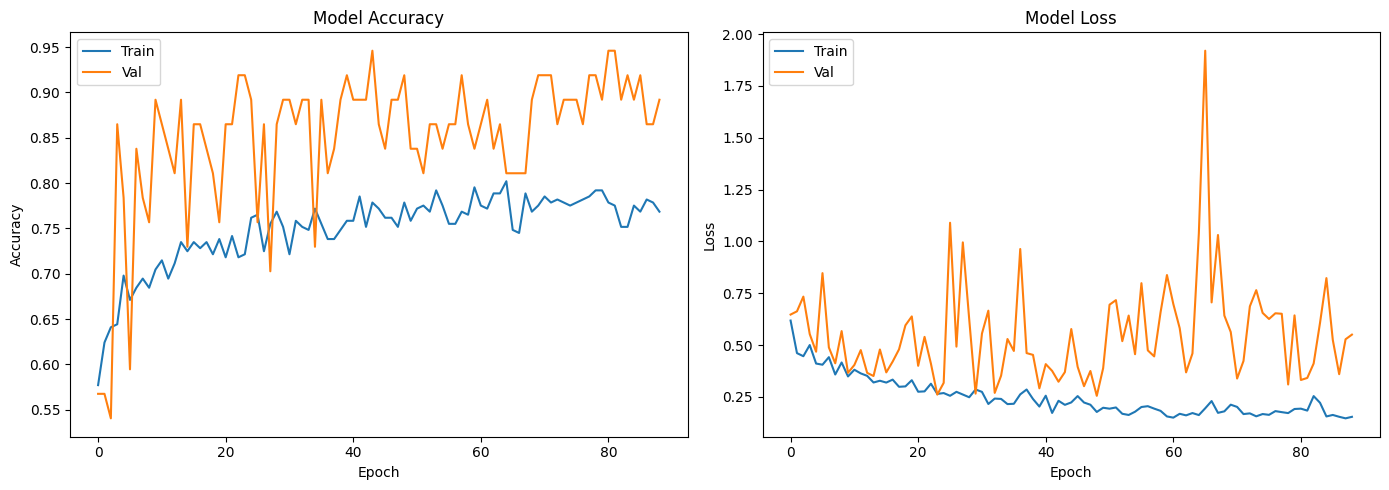

In [22]:
# Create a figure with a row of two subplots
plt.figure(figsize=(14, 5))

# Plot accuracy on the first subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot loss on the second subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
# plt.ylim((0, np.min([5, np.max([history.history['loss'], history.history['val_loss']])])))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Show the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [23]:
# steps = int(np.ceil(len(test_image_paths) / batch_size))
predictions = model.predict(test_gen)

6/6 [==============================] - 2s 383ms/step


In [24]:
y_preds = (predictions >= 0.5).astype(int).flatten()

In [25]:
y_true = np.concatenate([y for _, y in test_gen], axis=0) # [int(i > 0) for i in y_test]#

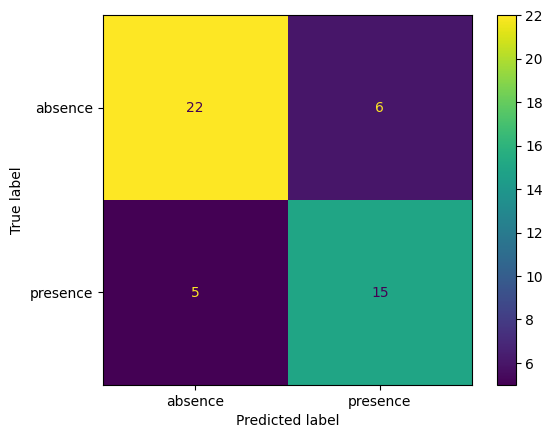

In [26]:
conf_mat = confusion_matrix(["presence" if i==1 else "absence" for i in y_true], ["presence" if i==1 else "absence" for i in y_preds])
disp = ConfusionMatrixDisplay(conf_mat, display_labels=["absence", "presence"])
disp.plot()

In [27]:
print(classification_report(y_true, y_preds, target_names=["absence", "presence"]))

              precision    recall  f1-score   support

     absence       0.81      0.79      0.80        28
    presence       0.71      0.75      0.73        20

    accuracy                           0.77        48
   macro avg       0.76      0.77      0.77        48
weighted avg       0.77      0.77      0.77        48



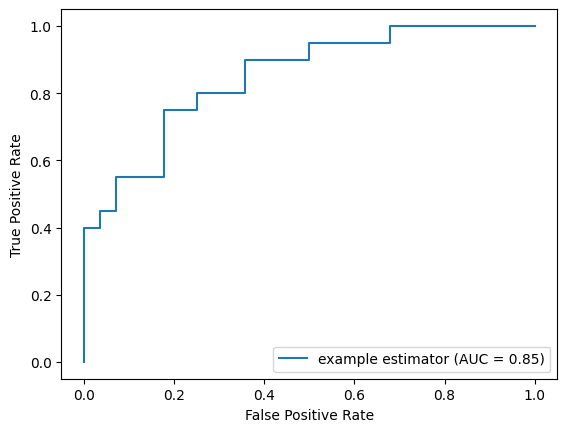

In [34]:
fpr, tpr, thresholds = roc_curve(y_true, predictions.flatten())
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()